In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels
import datetime as dt
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
register_matplotlib_converters()
from time import time

In [29]:
!kaggle datasets download milanzdravkovic/pharma-sales-data
!unzip pharma-sales-data.zip

Dataset URL: https://www.kaggle.com/datasets/milanzdravkovic/pharma-sales-data
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
pharma-sales-data.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  pharma-sales-data.zip
  inflating: salesdaily.csv          
  inflating: saleshourly.csv         
  inflating: salesmonthly.csv        
  inflating: salesweekly.csv         


In [39]:
daily = pd.read_csv('/content/salesdaily.csv')
weekly = pd.read_csv('/content/salesweekly.csv')
monthly = pd.read_csv('/content/salesmonthly.csv')

In [40]:
def print_shape(data):
    print('Rows : ',data.shape[0])
    print('Columns : ',data.shape[1])

In [41]:
print_shape(daily)
print_shape(weekly)
print_shape(monthly)

Rows :  2106
Columns :  13
Rows :  302
Columns :  9
Rows :  70
Columns :  9


In [42]:
monthly['datum'] = pd.to_datetime(monthly['datum'], format= '%Y-%m-%d')
weekly['datum'] = pd.to_datetime(weekly['datum'], format= '%m/%d/%Y')
daily['datum'] = pd.to_datetime(daily['datum'], format= '%m/%d/%Y')

In [43]:
monthly['year'] = monthly['datum'].dt.year
monthly['month'] = monthly['datum'].dt.month
monthly['day'] = monthly['datum'].dt.day
monthly.set_index(monthly['datum'], inplace=True)

In [44]:
num_col_list=['M01AB', 'M01AE', 'N02BA', 'N02BE', 'N05B', 'N05C', 'R03','R06']

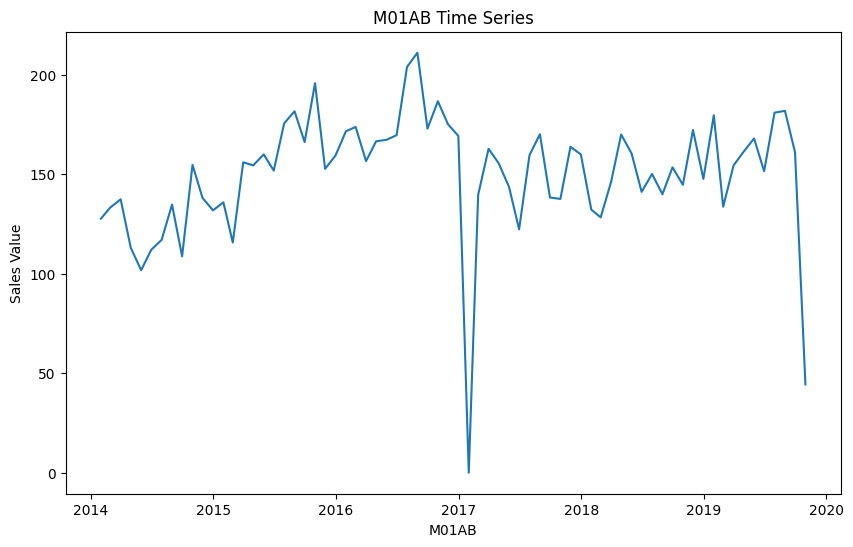

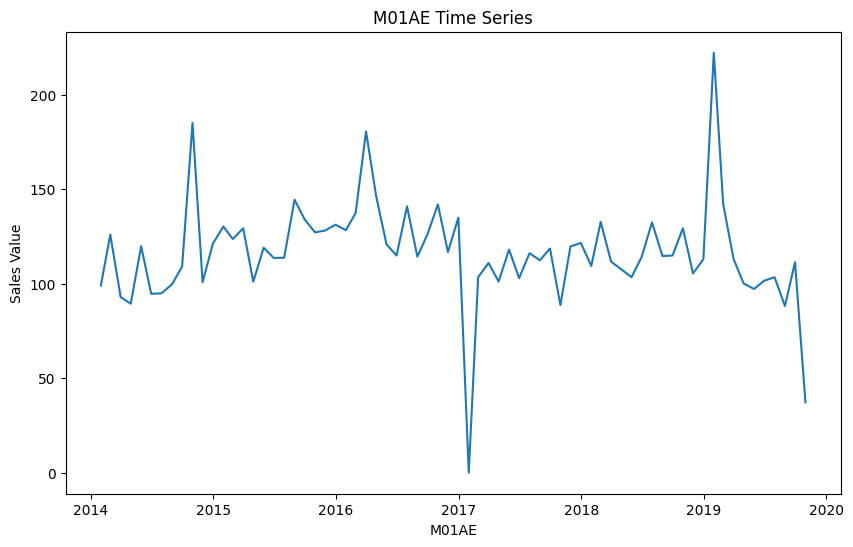

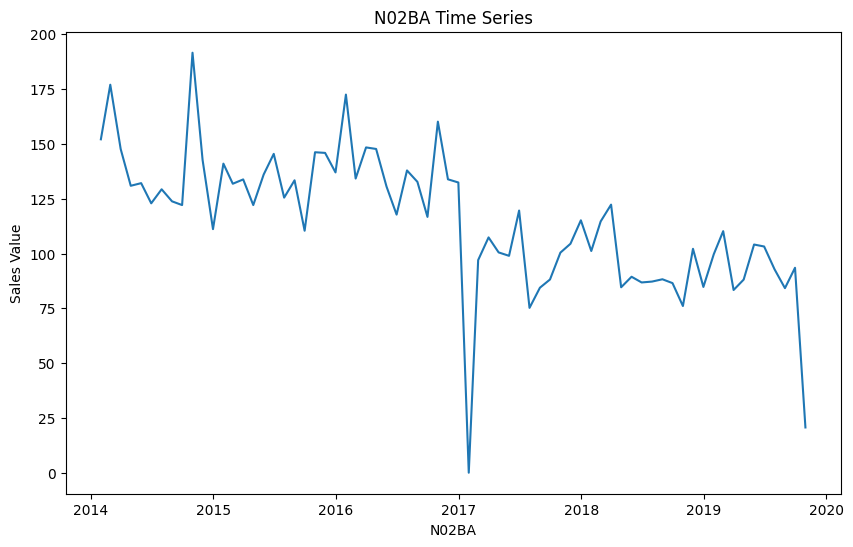

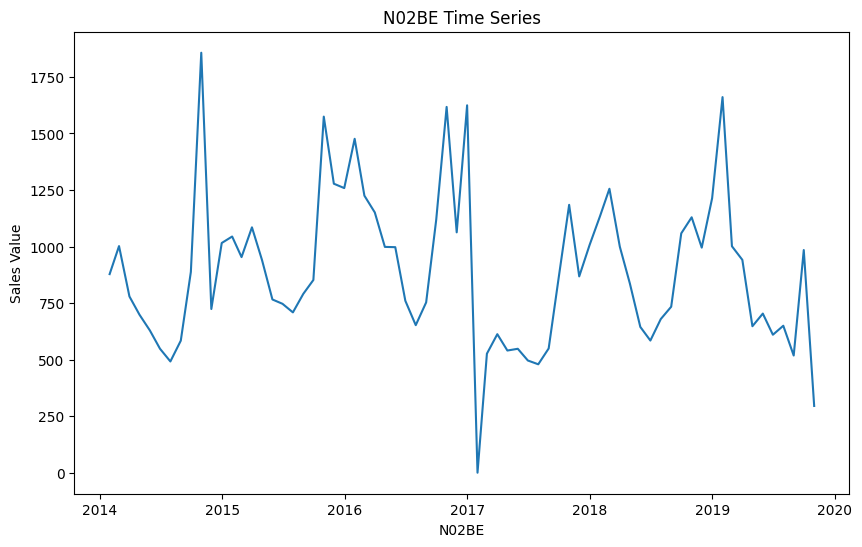

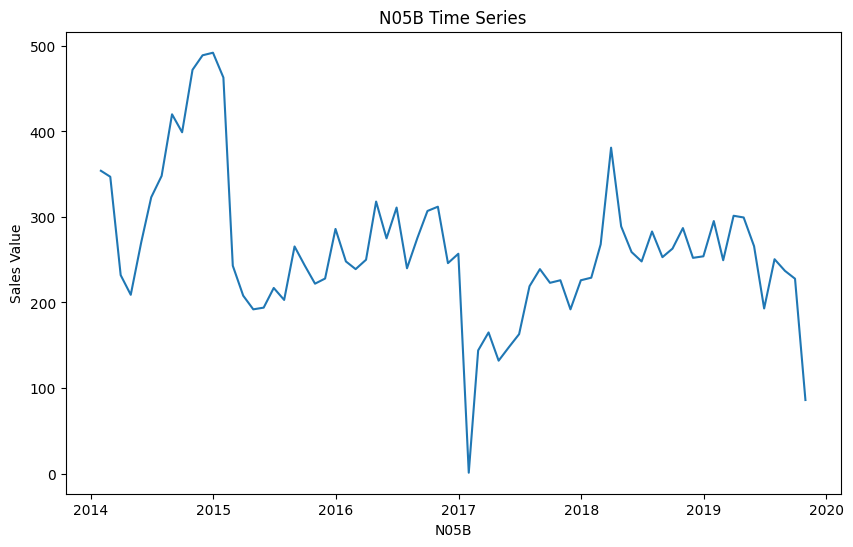

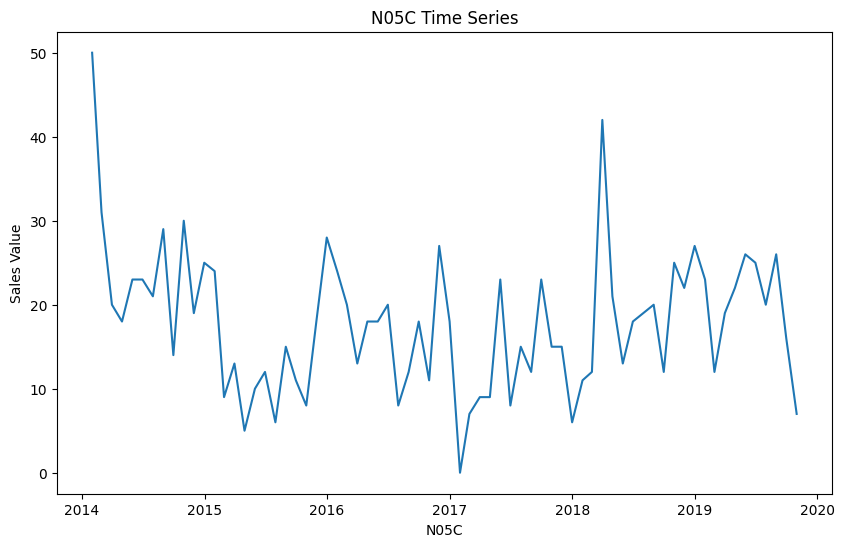

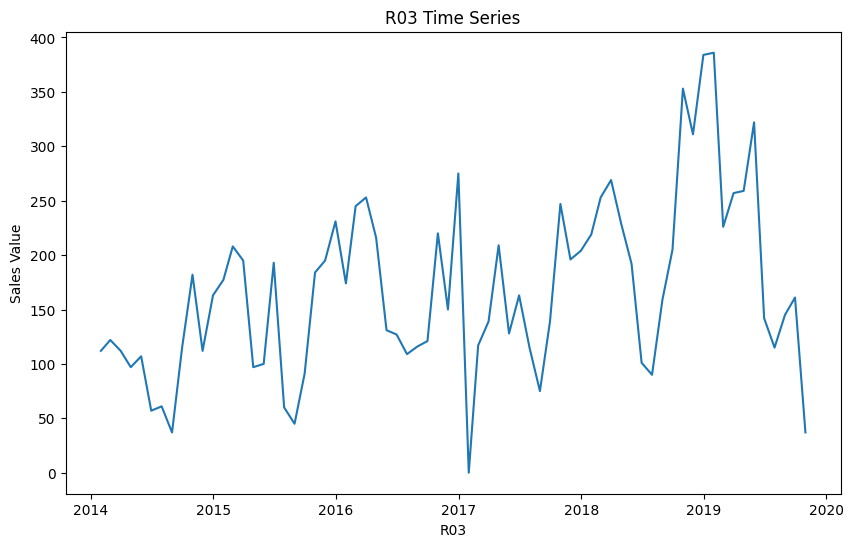

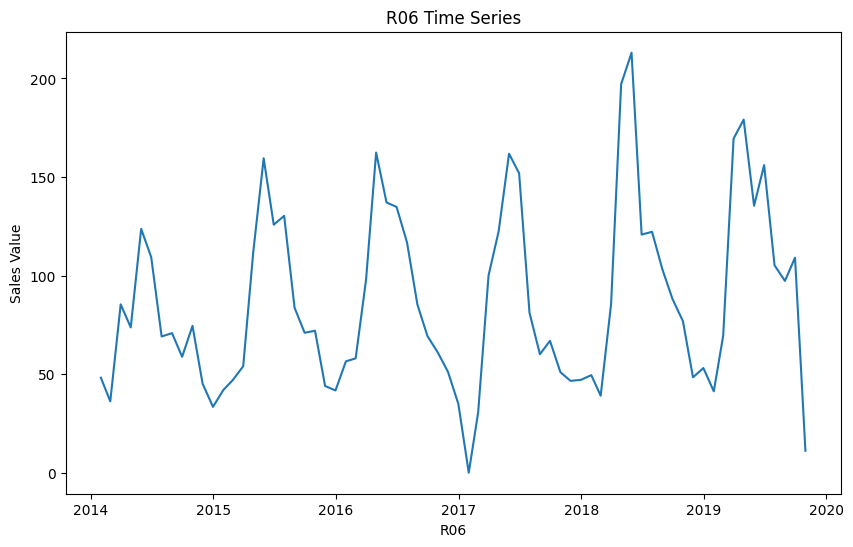

In [45]:
for column in num_col_list:
    plt.figure(figsize=(10, 6))
    plt.plot(monthly.index, monthly[column])
    plt.title(f'{column} Time Series')
    plt.xlabel(column)
    plt.ylabel('Sales Value')
    plt.show()

In [46]:
monthly['total_sales'] = monthly['M01AB']
for cols in monthly.columns[2:9]:
    monthly['total_sales'] = monthly['total_sales']+monthly[cols]

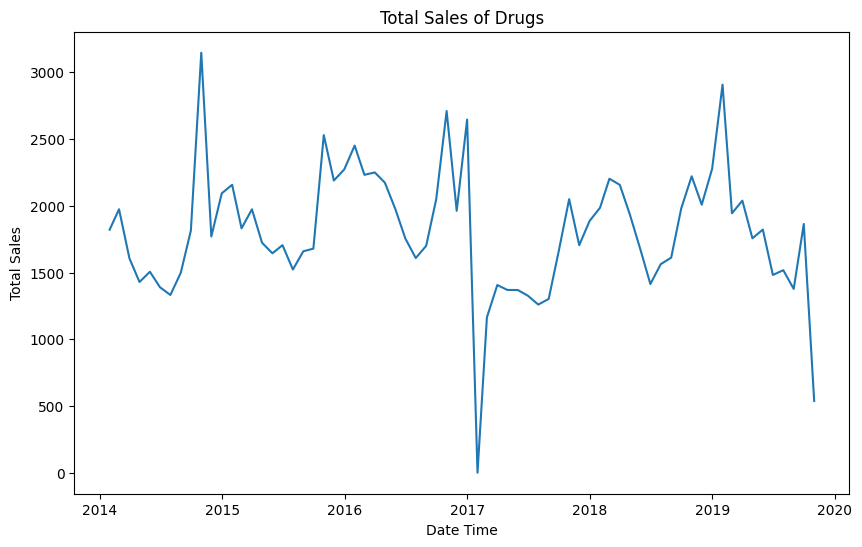

In [47]:
plt.figure(figsize=(10, 6))
plt.plot(monthly.index, monthly['total_sales'])
plt.xlabel('Date Time')
plt.ylabel('Total Sales')
plt.title('Total Sales of Drugs')
plt.show()

In [48]:
def perform_adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

In [49]:
perform_adf_test(monthly["total_sales"])

ADF Statistic: -3.378637
p-value: 0.011709


In [50]:
monthly = monthly.asfreq(pd.infer_freq(monthly.index))

In [51]:
train_end = dt.datetime(2019,7,31)
# test_end = datetime(2004,1,1) till end

train_data = monthly[:train_end]
test_data = monthly[train_end + dt.timedelta(days=1):]

In [52]:
model = statsmodels.tsa.ar_model.AutoReg(train_data["total_sales"], lags=1)
results = model.fit()

In [53]:
# Print model summary
print(results.summary())

                            AutoReg Model Results                             
Dep. Variable:            total_sales   No. Observations:                   67
Model:                     AutoReg(1)   Log Likelihood                -494.001
Method:               Conditional MLE   S.D. of innovations            430.924
Date:                Sat, 22 Feb 2025   AIC                            994.003
Time:                        16:54:54   BIC                           1000.572
Sample:                    02-28-2014   HQIC                           996.599
                         - 07-31-2019                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1170.2422    218.386      5.359      0.000     742.213    1598.272
total_sales.L1     0.3607      0.115      3.129      0.002       0.135       0.587
                                    

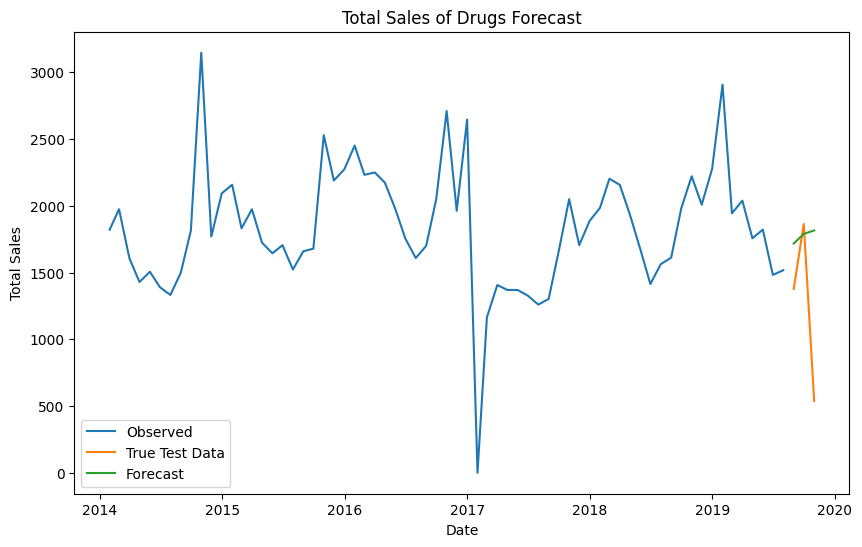

In [54]:
forecast = results.forecast(steps=3)

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data['total_sales'], label='Observed')
plt.plot(test_data.index, test_data['total_sales'], label='True Test Data')
plt.plot(forecast.index, forecast, label='Forecast')
plt.title('Total Sales of Drugs Forecast')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.show()

In [55]:
residuals = test_data["total_sales"] - forecast

In [56]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 764.2996381110047


Forecasting sales for M01AB
                            AutoReg Model Results                             
Dep. Variable:                  M01AB   No. Observations:                   67
Model:                     AutoReg(1)   Log Likelihood                -312.266
Method:               Conditional MLE   S.D. of innovations             27.450
Date:                Sat, 22 Feb 2025   AIC                            630.533
Time:                        17:08:03   BIC                            637.102
Sample:                    02-28-2014   HQIC                           633.129
                         - 07-31-2019                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        102.6163     17.913      5.728      0.000      67.506     137.726
M01AB.L1       0.3234      0.117      2.766      0.006       0.094       0.553
                        

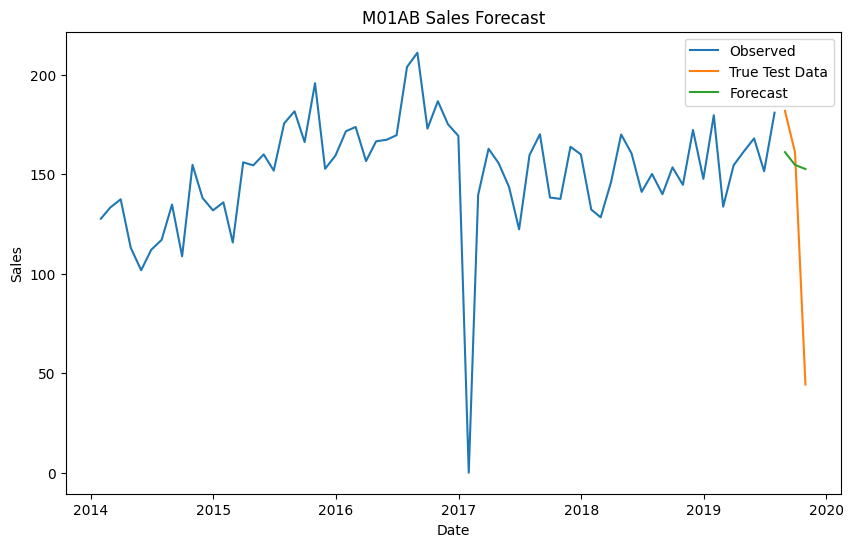

Root Mean Squared Error for M01AB: 63.76297959485228
--------------------------------------------------
Forecasting sales for M01AE
                            AutoReg Model Results                             
Dep. Variable:                  M01AE   No. Observations:                   67
Model:                     AutoReg(1)   Log Likelihood                -309.093
Method:               Conditional MLE   S.D. of innovations             26.162
Date:                Sat, 22 Feb 2025   AIC                            624.187
Time:                        17:08:03   BIC                            630.756
Sample:                    02-28-2014   HQIC                           626.783
                         - 07-31-2019                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        102.5230     14.774      6.939      0.000      73.567     131.479

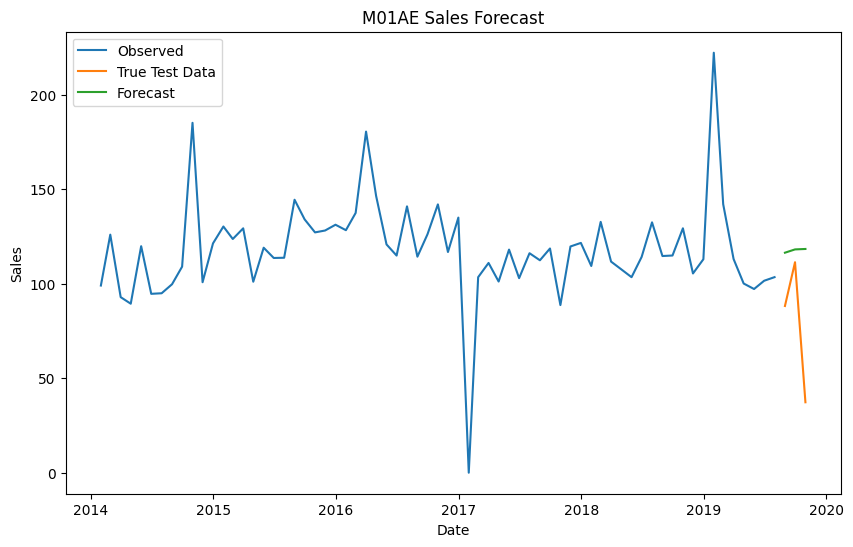

Root Mean Squared Error for M01AE: 49.76049751806274
--------------------------------------------------
Forecasting sales for N02BA
                            AutoReg Model Results                             
Dep. Variable:                  N02BA   No. Observations:                   67
Model:                     AutoReg(1)   Log Likelihood                -305.984
Method:               Conditional MLE   S.D. of innovations             24.958
Date:                Sat, 22 Feb 2025   AIC                            617.968
Time:                        17:08:04   BIC                            624.537
Sample:                    02-28-2014   HQIC                           620.564
                         - 07-31-2019                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         57.1663     12.763      4.479      0.000      32.152      82.181

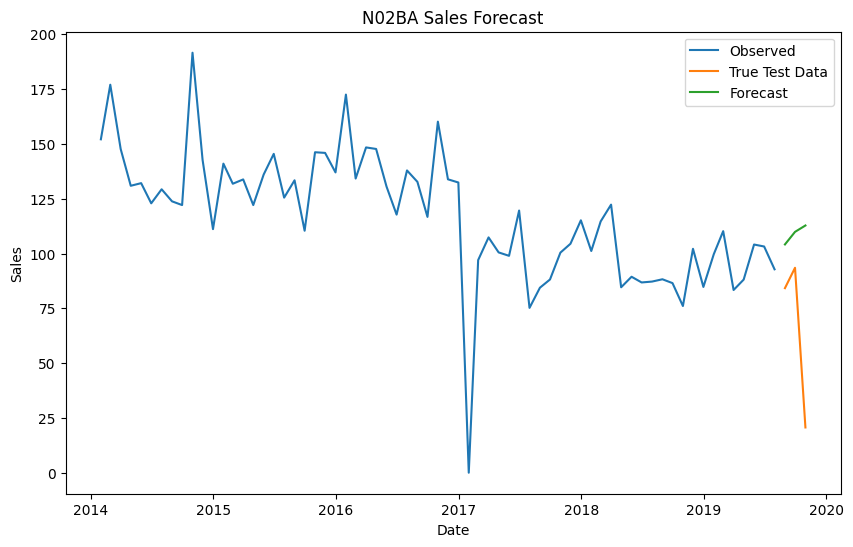

Root Mean Squared Error for N02BA: 55.239942172301824
--------------------------------------------------
Forecasting sales for N02BE
                            AutoReg Model Results                             
Dep. Variable:                  N02BE   No. Observations:                   67
Model:                     AutoReg(1)   Log Likelihood                -471.439
Method:               Conditional MLE   S.D. of innovations            306.150
Date:                Sat, 22 Feb 2025   AIC                            948.878
Time:                        17:08:04   BIC                            955.447
Sample:                    02-28-2014   HQIC                           951.474
                         - 07-31-2019                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        535.4978    109.481      4.891      0.000     320.920     750.07

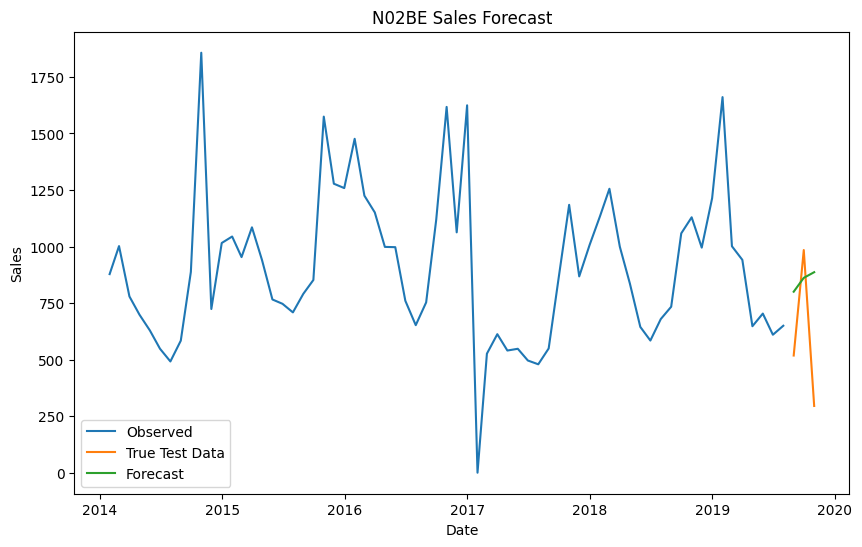

Root Mean Squared Error for N02BE: 384.90891128019337
--------------------------------------------------
Forecasting sales for N05B
                            AutoReg Model Results                             
Dep. Variable:                   N05B   No. Observations:                   67
Model:                     AutoReg(1)   Log Likelihood                -360.599
Method:               Conditional MLE   S.D. of innovations             57.093
Date:                Sat, 22 Feb 2025   AIC                            727.198
Time:                        17:08:04   BIC                            733.766
Sample:                    02-28-2014   HQIC                           729.793
                         - 07-31-2019                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         72.3657     23.334      3.101      0.002      26.631     118.100

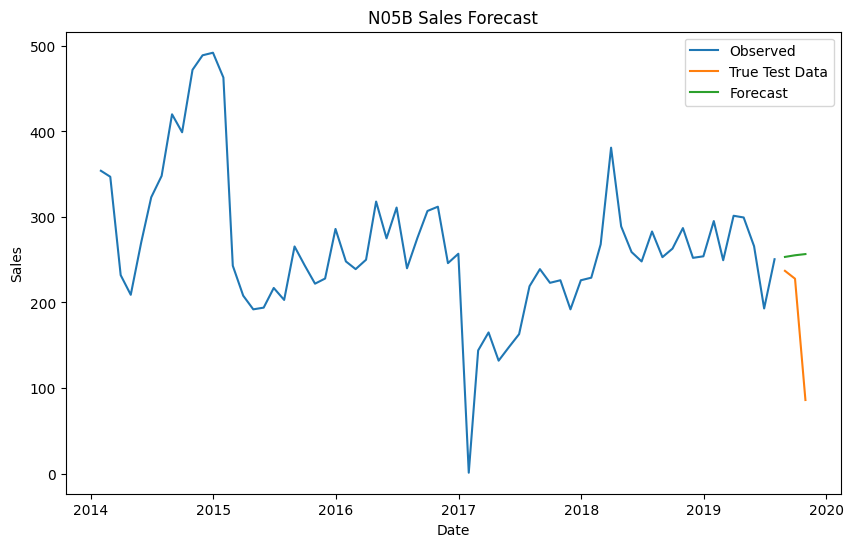

Root Mean Squared Error for N05B: 100.20419780706233
--------------------------------------------------
Forecasting sales for N05C
                            AutoReg Model Results                             
Dep. Variable:                   N05C   No. Observations:                   67
Model:                     AutoReg(1)   Log Likelihood                -222.807
Method:               Conditional MLE   S.D. of innovations              7.078
Date:                Sat, 22 Feb 2025   AIC                            451.615
Time:                        17:08:05   BIC                            458.183
Sample:                    02-28-2014   HQIC                           454.210
                         - 07-31-2019                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.0940      2.029      5.962      0.000       8.118      16.070


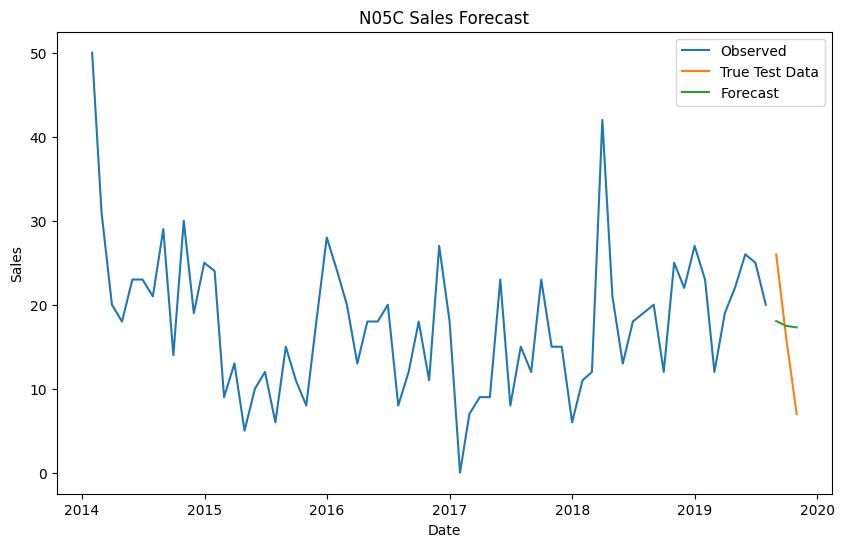

Root Mean Squared Error for N05C: 7.560042206140241
--------------------------------------------------
Forecasting sales for R03
                            AutoReg Model Results                             
Dep. Variable:                    R03   No. Observations:                   67
Model:                     AutoReg(1)   Log Likelihood                -369.780
Method:               Conditional MLE   S.D. of innovations             65.613
Date:                Sat, 22 Feb 2025   AIC                            745.559
Time:                        17:08:05   BIC                            752.128
Sample:                    02-28-2014   HQIC                           748.155
                         - 07-31-2019                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         69.2915     18.731      3.699      0.000      32.580     106.003
R0

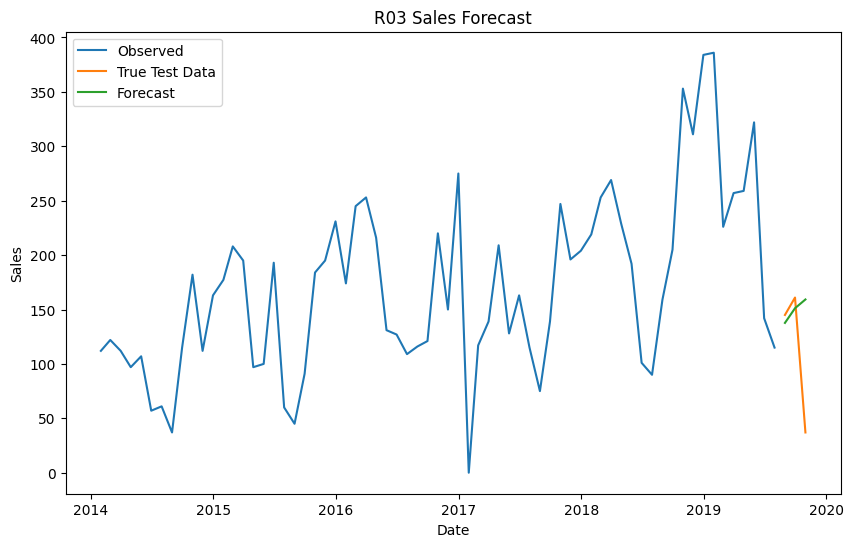

Root Mean Squared Error for R03: 70.91777713018065
--------------------------------------------------
Forecasting sales for R06
                            AutoReg Model Results                             
Dep. Variable:                    R06   No. Observations:                   67
Model:                     AutoReg(1)   Log Likelihood                -323.614
Method:               Conditional MLE   S.D. of innovations             32.600
Date:                Sat, 22 Feb 2025   AIC                            653.228
Time:                        17:08:05   BIC                            659.797
Sample:                    02-28-2014   HQIC                           655.824
                         - 07-31-2019                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.3150      8.616      3.170      0.002      10.427      44.203
R06

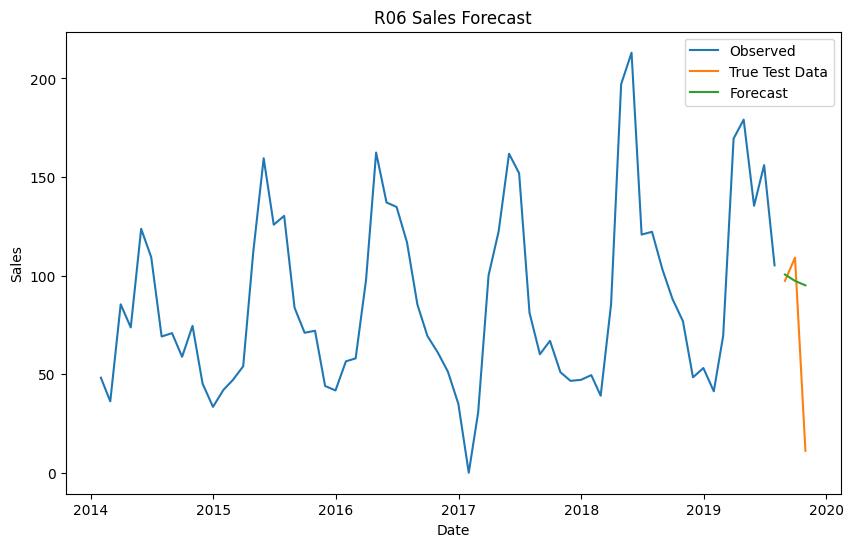

Root Mean Squared Error for R06: 48.95667780187132
--------------------------------------------------


In [63]:
for drug in num_col_list:
    print(f"Forecasting sales for {drug}")
    train_data_drug = train_data[[drug]]
    test_data_drug = test_data[[drug]]

    model_drug = statsmodels.tsa.ar_model.AutoReg(train_data_drug[drug], lags=1)
    results_drug = model_drug.fit()
    print(results_drug.summary())
    forecast_drug = results_drug.forecast(steps=len(test_data_drug))

    plt.figure(figsize=(10, 6))
    plt.plot(train_data_drug.index, train_data_drug[drug], label='Observed')
    plt.plot(test_data_drug.index, test_data_drug[drug], label='True Test Data')
    plt.plot(test_data_drug.index, forecast_drug, label='Forecast')
    plt.title(f'{drug} Sales Forecast')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()

    residuals_drug = test_data_drug[drug] - forecast_drug
    rmse_drug = np.sqrt(np.mean(residuals_drug**2))
    print(f'Root Mean Squared Error for {drug}:', rmse_drug)
    print("-" * 50)


In [65]:
for drug in num_col_list:
    print(f"Forecast values for {drug}:")
    train_data_drug = train_data[[drug]]
    test_data_drug = test_data[[drug]]
    model_drug = statsmodels.tsa.ar_model.AutoReg(train_data_drug[drug], lags=1)
    results_drug = model_drug.fit()
    forecast_drug = results_drug.forecast(steps=len(test_data_drug))
    for i, value in enumerate(forecast_drug):
        print(f"  Month {i+1}: {value}")
    print("-" * 50)


Forecast values for M01AB:
  Month 1: 161.15188393890662
  Month 2: 154.7329791104454
  Month 3: 152.657097496794
--------------------------------------------------
Forecast values for M01AE:
  Month 1: 116.47850765391776
  Month 2: 118.22225964887836
  Month 3: 118.4572872215197
--------------------------------------------------
Forecast values for N02BA:
  Month 1: 104.13884466881635
  Month 2: 109.8782253268478
  Month 3: 112.78332644604536
--------------------------------------------------
Forecast values for N02BE:
  Month 1: 800.2581265020971
  Month 2: 861.5621384824923
  Month 3: 886.5403963690151
--------------------------------------------------
Forecast values for N05B:
  Month 1: 253.27750498483016
  Month 2: 255.21043517593296
  Month 3: 256.6058458828578
--------------------------------------------------
Forecast values for N05C:
  Month 1: 18.056642361728613
  Month 2: 17.47726643007786
  Month 3: 17.304536272969592
--------------------------------------------------
Fore

In [66]:
import datetime as dt
drug_name = input("Enter the drug name (e.g., M01AB, M01AE, etc.): ")
if drug_name not in num_col_list:
    print("Invalid drug name. Please enter a valid drug name from the list.")
else:
    train_data_drug = train_data[[drug_name]]
    test_data_drug = test_data[[drug_name]]
    model_drug = statsmodels.tsa.ar_model.AutoReg(train_data_drug[drug_name], lags=1)
    results_drug = model_drug.fit()
    num_months = int(input("Enter the number of months to forecast: "))
    forecast_drug = results_drug.forecast(steps=num_months)
    print(f"Forecasted sales for {drug_name} for the next {num_months} months:")
    for i, value in enumerate(forecast_drug):
      print(f"Month {i+1}: {value}")


Enter the drug name (e.g., M01AB, M01AE, etc.): M01AB
Enter the number of months to forecast: 2
Forecasted sales for M01AB for the next 2 months:
Month 1: 161.15188393890662
Month 2: 154.7329791104454
